In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

<h1> A Machine Learning Model for Solar Flare Predictions </h1>

<h3> Author: Martin Nedev </h3>

<h2>I. Overview</h2>

<h3> What is a solar flare? </h3>

A solar flare is a powerful electromagnetic radioactive eruption of the Sun. It occurs in active regions(AR) which are charactirized with magnetic abnormlities - extremely strong and complex magnetic field. A solar flare can release energy of $10^{21}$ to $10^{25}$ J. This leads to disruptions in radio communication technologies and even fallouts. For example, the biggest solar flare ever recorded, happened in 1859 and caused auroras, which could be seen from the Carribean, blackouts and failiure of most telegraph systems over North America and Europe. That is why scientist are trying to find a way to predict when an event like this would happen.

<h3> Types of solar flares </h3>

Solar flares are classified in 5 main groups based on their strength and intensity: A, B, C, M and L (A is the weakest, L is the largest). Each of them is divided into subclasses which add numbers after the letter of the main class. The numbers range from 1 to 10 (excluding it) and can be fractions.

**Example**: B7.1, X2.3, C9.0, M1.0, C7.8, etc.

The number of the subclass shows how much more powerful is this flare compared to the first type of the main class.

**Example**: M2.0 is 2 times more powerful than M1.0, M3.0 is 3 times more powerful than M1.0, M4.0 is 4 times more powerful than M1.0 and so on.

***N.B. In this reasearch we will only analyze and predict flares that are types C, M and L, because A and B are very weak, do not cause much interest and often they are not even written in datasets.***

<h3> Purpose of this research </h3>

The main objective of the research is to create a model which can be used for predictions of incomming solar flares and their classification in the types explained above. This is important beacuse it might be used to prepare sattelites and electronics to suffer the minimal damage. Another thing that this research intends is to find which physical quantities affect the solar flare and by which it is most dependend. This can give scientists an explanation of how this event happens and what causes it.   

<h3> What previous researches have been done on this topic (resources)? </h3>

There have been several previous researches made on this topic. Here are some of them that I could find:

* Predicting Solar Flares Using SDO/HMI Vector Magnetic Data Products and the Random Forest Algorithm - Chang Liu, Na Deng, Jason T. L. Wang and Haimin Wang - 2017
 
* SOLAR FLARE PREDICTION USING SDO/HMI VECTOR MAGNETIC FIELD DATA WITH A MACHINE-LEARNING ALGORITHM - M. G. Bobra and S. Couvidat - 2015
* MACHINE LEARNING MODEL SURVEY WITH THE DATASET FOR SOLAR FLARE PREDICTION - Erik Larsen 


These three researches have helped me a lot in this project, especially in the data extraction - choosing the datasets and the physical qualities. 

Other resources:
* Wikipedia
* Nasa
* "Спокойно и активно Слънце" - Владимир Дерменджиев, 1997 г.

<h3> Special thanks </h3>

I want to express gratitude to Mrs. Joanna Kokotanekova from Astronomical Observatory in Haskovo, who helped me a with the understanding of the astronomical part of this research.

<h2>II Data Extraction</h2>

For these research I get data from three datasets. The first one is JSOC's hmi_sharp_720s. The SHARP dataset (Spaceweather HMI Active Region Patch) is series of different quantities which are calculated from the photospheric vector magnitogram (mostly captured by SDO). The second dataset is also from JSOC and this is cgem.Lorentz which gives information about the lorentz force of the different active regions based on their HMI vector magnitogram. Both cgem.Lorentz and hmi_sharp_720s give information every 12 minutes. The final data that I used was from the website **solarmonitor.org**. It gives information about the type of flares that have happened in certain AR(Active Region) in each date. 

To extract hmi_sharp_720s and cgem.Lorentz from JSOC I will use the library **drms** which is designed to give an easy access to the data. I am making queries for 10 days period because if it is smaller, it becomes very slow and if it is larger - some of the data got lost.

In [3]:
#date format 2022.11.01_00:00:00-2022.11.02_00:00:00
import drms

def extractDataFromHMI_SHARP_720s(year):
    
    dataFrame = pd.DataFrame()
    currDate = datetime(year, 1, 11)
    pastDate = currDate + timedelta(days = -10)

    while currDate.year < year+1:
        
        pastDateStr = pastDate.strftime('%Y.%m.%d_%H:%M:%S')
        currDateStr = currDate.strftime('%Y.%m.%d_%H:%M:%S')
        
        url = pastDateStr + '-' + currDateStr
        #print(url)
        
        #extract data query
        client = drms.Client()
        dataFrameQuery = client.query(
        'hmi.sharp_720s[][' + url + ']',
        key='T_REC,HARPNUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,AREA_ACR,MEANPOT,R_VALUE,SHRGT45,MEANSHR,MEANGAM,NOAA_AR,QUALITY'
        )
        
        #add the new data to the dataframe and change days
        dataFrame = pd.concat([dataFrame, dataFrameQuery], ignore_index= True)
        currDate = currDate + timedelta(days = 10)
        pastDate = pastDate + timedelta(days = 10)
        
        #check if we have surpassed the current year
        if pastDate.year != currDate.year:
            currDate = datetime(pastDate.year, 12, 31, 23, 59, 59)
            
    #converting the data frame to .csv file for the current year    
    dataFrame.to_csv('data/HMI_SHARP_720s/HMI_SHARP_720s_' + str(year) + '.csv')
    
def extractDataFromCgemLorentz(year):
    
    dataFrame = pd.DataFrame()
    currDate = datetime(year, 1, 11)
    pastDate = currDate + timedelta(days = -10)

    while currDate.year < year+1:
        
        pastDateStr = pastDate.strftime('%Y.%m.%d_%H:%M:%S')
        currDateStr = currDate.strftime('%Y.%m.%d_%H:%M:%S')
        
        url = pastDateStr + '-' + currDateStr
        #print(url)
        
        #extract data query        
        client = drms.Client()
        dataFrameQuery = client.query(
            'cgem.lorentz[][' + url + ']',
            key='T_REC,HARPNUM, TOTBSQ, TOTFZ, EPSZ, NOAA_AR, QUALITY'
        )
        
        #add the new data to the dataframe and change days
        dataFrame = pd.concat([dataFrame, dataFrameQuery], ignore_index = True)
        currDate = currDate + timedelta(days = 10)
        pastDate = pastDate + timedelta(days = 10)
        
        #check if we have surpassed the current year        
        if pastDate.year != currDate.year:
            currDate = datetime(pastDate.year, 12, 31, 23, 59, 59)
            
    #converting the data frame to .csv file for the current year
    dataFrame.to_csv('data/cgemLorentz/cgemLorentz_' + str(year) + '.csv')
    
def extractDataFromSolarMonitor(year):
    
    dataFrame = pd.DataFrame()
    
    currDate = date(year, 1, 1)
    if year == 2010:
        currDate = date(year, 5, 1)
    
    while currDate.year < year+1:
        dateStr = currDate.strftime('%Y%m%d')
        url = 'https://www.solarmonitor.org/index.php?date=' + dateStr
        #print(url)
        
        #extract data query
        df = pd.read_html(url)
        for i in range(0, len(df)):
            if df[i][0][0] == "Today's/Yesterday's NOAA Active Regions":
                df = df[i]
                break

        #format table and set headers
        df = df.drop([0]).reset_index()
        df.rename(columns = df.iloc[0], inplace = True)
        df = df.drop([0]).reset_index()
        df = df.drop(columns = ['index', 1])
        df.insert(0, 'Date', currDate.strftime('%Y.%m.%d'))


        dataFrame = pd.concat([dataFrame, df], ignore_index = True)
        currDate = currDate + timedelta(days = 1)
        
    #converting the data frame to .csv file for the current year
    dataFrame.to_csv('data/Solar Monitor/Solar_Monitor_' + str(year) + '.csv')

<h4>Important! - if you start extracting the data, the whole process will take 3-4 hours.</h4>

In [ ]:
for i in range (2010, 2022+1):
    print (f'Currently extracting data from the year {i}')
    extractDataFromHMI_SHARP_720s(i)
    extractDataFromCgemLorentz(i)
    extractDataFromSolarMonitor(i)

Now we should merge the .csv files for each year into one dataframe (for hmi_sharp_720s and cgem.Lorentz).

In [4]:
hmiSHARP_df = pd.DataFrame()
for i in range(2010, 2022+1):
    currYear_df = pd.read_csv(f'data/HMI_SHARP_720s/HMI_SHARP_720s_{i}.csv')
    #print(f'In year {i} -> {currYear_df.shape}')
    hmiSHARP_df = pd.concat([hmiSHARP_df, currYear_df], ignore_index = True)
    
cgemLorentz_df = pd.DataFrame()
for i in range (2010, 2022+1):
    currYear_df = pd.read_csv(f'data/cgemLorentz/cgemLorentz_{i}.csv')
    #print(f'In year {i} -> {currYear_df.shape}')
    cgemLorentz_df = pd.concat([cgemLorentz_df, currYear_df], ignore_index = True)

Let's see what the shape tables looks like!

In [5]:
hmiSHARP_df.head(10)

,Unnamed: 0,T_REC,HARPNUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,AREA_ACR,MEANPOT,R_VALUE,SHRGT45,MEANSHR,MEANGAM,NOAA_AR,QUALITY
0,0,2010.05.01_00:00:00_TAI,1,270.853,2.905448e+22,5.777592e+12,30.270,2.383632e+12,6.510776e+21,107.599098,2242.021,3.343,8.690,24.064,28.337,11067,66560
1,1,2010.05.01_00:00:00_TAI,2,134.868,1.347732e+22,2.546539e+12,10.328,1.971602e+11,1.846205e+21,96.961456,4031.880,0.000,7.906,26.630,35.247,11064,66560
2,2,2010.05.01_00:00:00_TAI,5,47.344,2.244250e+21,1.112781e+12,7.635,7.572959e+11,6.077373e+20,55.685177,1645.463,0.000,4.576,22.872,28.000,0,66560
3,3,2010.05.01_00:00:00_TAI,6,47.986,2.527947e+21,1.101597e+12,2.771,2.119854e+11,6.642536e+20,55.227554,1704.128,0.000,6.177,23.890,29.764,11065,66560
4,4,2010.05.01_00:00:00_TAI,1,270.853,2.905448e+22,5.777592e+12,30.270,2.383632e+12,6.510776e+21,107.599098,2242.021,3.343,8.690,24.064,28.337,11067,66560
5,5,2010.05.01_00:12:00_TAI,1,264.299,3.306497e+22,5.654726e+12,12.939,6.364629e+11,6.521054e+21,105.709244,2461.199,3.642,11.418,24.950,29.678,11067,0
6,6,2010.05.01_00:24:00_TAI,1,307.572,3.353350e+22,6.488687e+12,11.460,1.174558e+12,6.917875e+21,111.348442,2365.145,3.357,9.489,23.755,28.441,11067,0
7,7,2010.05.01_00:36:00_TAI,1,297.073,3.071844e+22,6.193157e+12,17.791,2.019295e+12,6.973706e+21,108.848373,2194.344,3.544,9.012,24.017,28.031,11067,0
8,8,2010.05.01_00:48:00_TAI,1,301.562,2.774973e+22,5.797055e+12,3.262,8.275204e+11,7.228647e+21,104.785210,1970.685,3.073,6.130,21.072,26.980,11067,0
9,9,2010.05.01_01:00:00_TAI,1,316.165,3.083054e+22,6.081439e+12,5.010,8.021213e+11,7.361199e+21,106.967400,2133.142,3.332,6.377,21.730,26.925,11067,0


In [6]:
cgemLorentz_df.head(10)

,Unnamed: 0,T_REC,HARPNUM,TOTBSQ,TOTFZ,EPSZ,NOAA_AR,QUALITY
0,0,2010.05.01_00:00:00_TAI,1,NaN,NaN,NaN,11067,66560
1,1,2010.05.01_00:00:00_TAI,2,3.595200e+09,-215.070,-0.1135,11064,66560
2,2,2010.05.01_00:00:00_TAI,5,6.942900e+08,-64.452,-0.1761,0,66560
3,3,2010.05.01_00:00:00_TAI,6,8.663200e+08,-51.788,-0.1134,11065,66560
4,4,2010.05.01_00:00:00_TAI,1,NaN,NaN,NaN,11067,66560
5,5,2010.05.01_00:12:00_TAI,1,NaN,NaN,NaN,11067,0
6,6,2010.05.01_00:24:00_TAI,1,NaN,NaN,NaN,11067,0
7,7,2010.05.01_00:36:00_TAI,1,NaN,NaN,NaN,11067,0
8,8,2010.05.01_00:48:00_TAI,1,NaN,NaN,NaN,11067,0
9,9,2010.05.01_01:00:00_TAI,1,NaN,NaN,NaN,11067,0


In [7]:
print (hmiSHARP_df.shape, cgemLorentz_df.shape) 

(3208822, 17) (3183968, 8)


There is a difference in the number of rows between hmiSHARP_df and cgemLorentz_df so we will need to fix that when we are merging the two dataframes.

Now we should drop all rows which have unspecified number of the active region(NOAA_AR) because this events cannot be associated with flare event from solar monitor (they give information about flares only for NOAA active regions).

In [8]:
hmiSHARP_df = hmiSHARP_df[hmiSHARP_df['NOAA_AR'] != 0]
cgemLorentz_df = cgemLorentz_df[cgemLorentz_df['NOAA_AR'] != 0]

In [9]:
print (hmiSHARP_df.shape, cgemLorentz_df.shape) 

(1823460, 17) (1811144, 8)


This removed almost half of the data.

Second, there is a column QUALITY in the datasets. It tells us how much noise there is in the magnitogram - the lower the number, the better (the best is 0). I decided to remove all the data that has any noise because it could affect the physical qualities and thus give an unappropriate result. 

In [10]:
hmiSHARP_df = hmiSHARP_df[hmiSHARP_df['QUALITY'] == 0] 
cgemLorentz_df = cgemLorentz_df[cgemLorentz_df['QUALITY']== 0]

In [11]:
print (hmiSHARP_df.shape, cgemLorentz_df.shape) 

(1719977, 17) (1598103, 8)


And finally there are rows where all of the data is **NaN**, so they are not needed. 

In [12]:
cgemLorentz_df = cgemLorentz_df.dropna()
hmiSHARP_df = hmiSHARP_df.dropna()

In [13]:
print (hmiSHARP_df.shape, cgemLorentz_df.shape) 

(1702344, 17) (1381529, 8)


Now let's combine all .csv files from solar monitor to one dataframe.

In [14]:
solarMonitor_df = pd.DataFrame()
for i in range (2010, 2022+1):
    currYear_df = pd.read_csv(f'data/Solar monitor/Solar_monitor_{i}.csv') 
    solarMonitor_df = pd.concat([solarMonitor_df, currYear_df], ignore_index = True)

In [15]:
solarMonitor_df.head(10)

,Unnamed: 0,Date,NOAA Number,Latest Position,Hale Class,McIntosh Class,Sunspot Area [millionths],Number of Spots,Recent Flares
0,0,2010.05.01,11064,"N15E14(-222"",136"")",β/β,Bxo/Bxo,0020/0020,02/02,-
1,1,2010.05.02,11064,"N16E01(-15"",149"")",β/β,Cro/Bxo,0010/0020,03/02,-
2,2,2010.05.02,11065,"S32W30(403"",-584"")",α/-,Axx/---,0000/----,01/--,-
3,3,2010.05.02,11066,"S27E02(-29"",-531"")",α/-,Axx/---,0000/----,01/--,-
4,4,2010.05.02,11067,"N23E41(-574"",289"")",β/-,Bxo/---,0020/----,04/--,-
5,5,2010.05.03,11063,"N18W66(825"",246"")",β/-,Bxo/---,0010/----,02/--,-
6,6,2010.05.03,11064,"N15W12(191"",135"")",α/β,Axx/Cro,0000/0010,01/03,-
7,7,2010.05.03,11065,"S32W30(403"",-584"")",α/α,Axx/Axx,0000/0000,01/01,-
8,8,2010.05.03,11066,"S27E02(-29"",-531"")",α/α,Axx/Axx,0000/0000,01/01,-
9,9,2010.05.03,11067,"N23E41(-574"",289"")",β/β,Bxo/Bxo,0020/0020,04/04,-


In [16]:
print (solarMonitor_df.shape)

(18726, 9)


In the data from solar monitor there are all the flares which have happened in a specific AR for each day. We should format this column, so it only gives us 4 types of events - C, M, X and No Flare (also NaN for days when there is no data, but we will delete them after that). We will classify the type of flare of each AR by taking the strongest that has happened in the day.

In [17]:
for i in range(0, len(solarMonitor_df['Recent Flares'])):
    curr = str(solarMonitor_df['Recent Flares'][i])

    #print(curr)
    if curr == 'No Data Available For This Day':
        solarMonitor_df.at[i, 'Recent Flares'] = 'NaN'
        continue

    isX = curr.find('X')
    isM = curr.find('M')
    isC = curr.find('C')

    if isX != -1:
        solarMonitor_df.at[i, 'Recent Flares'] = 'X'
        continue

    if isM != -1:
        solarMonitor_df.at[i, 'Recent Flares'] = 'M'
        continue

    if isC != -1:
        solarMonitor_df.at[i, 'Recent Flares'] = 'C'
        continue

    solarMonitor_df.at[i, 'Recent Flares'] = 'No Flares'

Rename the column Recent Flares to FLARE_CLASS and get the count of each type.

In [18]:
solarMonitor_df = solarMonitor_df.rename(columns = {'Recent Flares':'FLARE_CLASS'})
solarMonitor_df['FLARE_CLASS'].value_counts()

No Flares    14757
C             3245
M              586
NaN             74
X               64
Name: FLARE_CLASS, dtype: int64

<BarContainer object of 4 artists>

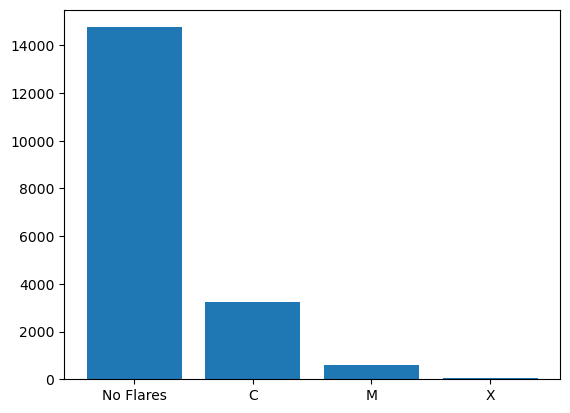

In [19]:
#delete NaN
solarMonitor_df = solarMonitor_df[solarMonitor_df['FLARE_CLASS'] != 'NaN']
plt.bar(['No Flares', 'C', 'M', 'X'], solarMonitor_df['FLARE_CLASS'].value_counts())

As you can see from the plot, there is a large ammount of C and No Flares, and very small of M and X. That is totally expected.

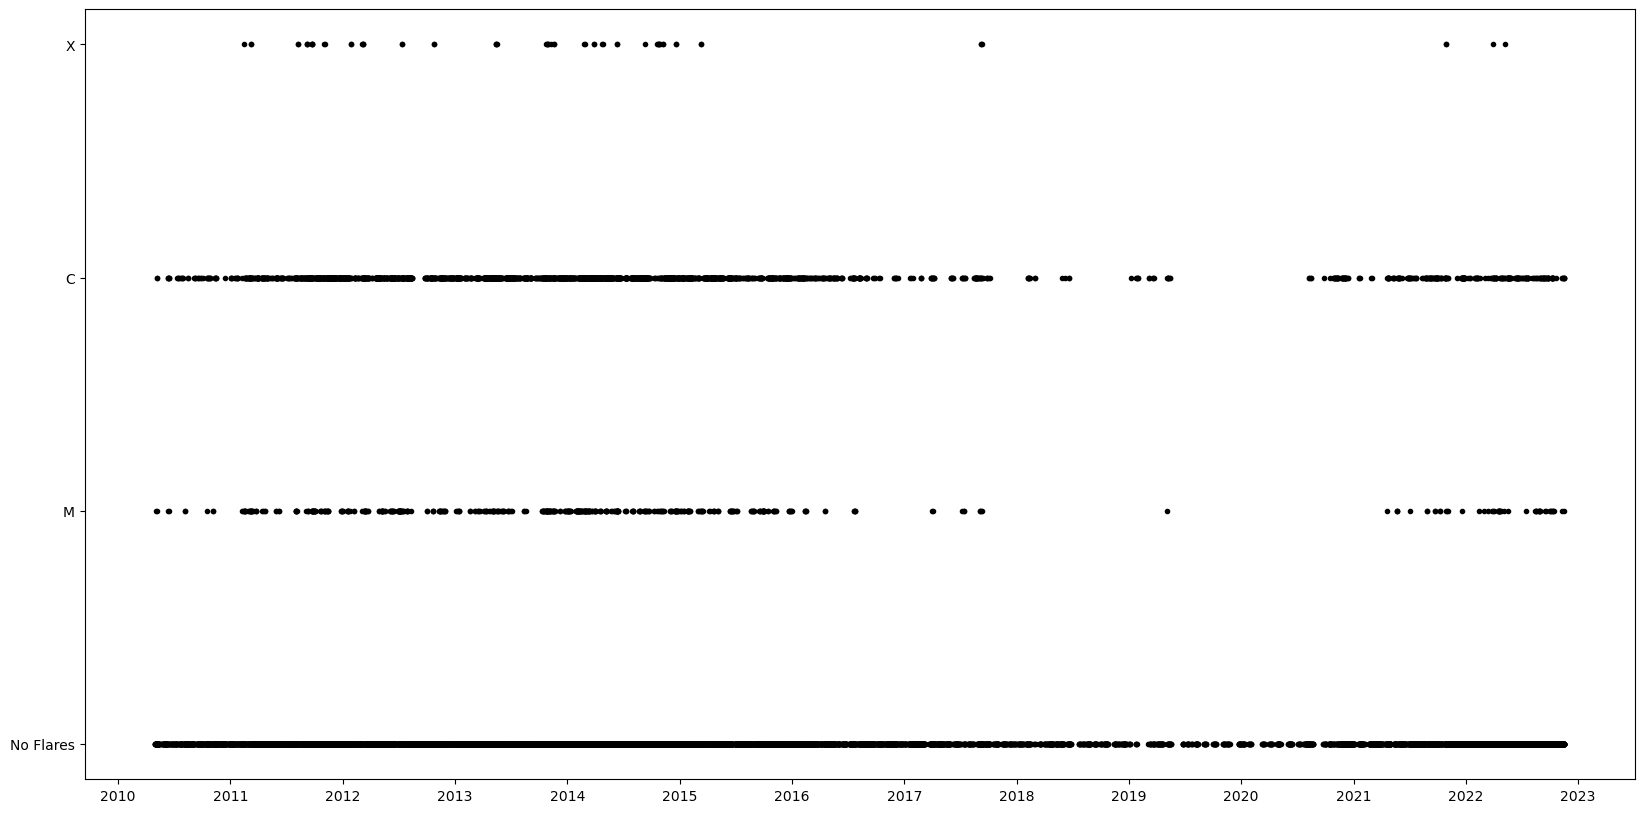

In [20]:
import matplotlib.dates as pltdates

dates = pd.to_datetime(solarMonitor_df['Date'])
classes = solarMonitor_df['FLARE_CLASS']
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(pltdates.YearLocator())
plt.plot(dates, classes, '.', color = 'black')

This plot visualises that in the period 2017-2021 there is a decrease in the number of occurrences of solar flares. That is because the Sun has an activity period which changes every 11 years. This activity period has maximum and minimum and when two cycles change solar activity is very low. This happened between 2017-2021. Just an interesting fact. :)

The only thing that remains is to merge all the dataframes to one. First we will merge hmi_sharp_720s and cgem.Lorentz. In order to do that we need to sort the datasets by their time of observation (column 'T_REC') and their NOAA AR number (column 'NOAA_AR'), because as we showed above there are different number of rows in the two datasets and observations in the first may not appear in the second and vice versa.

In [21]:
final_df = hmiSHARP_df
newColumns = ['TOTBSQ', 'TOTFZ', 'EPSZ', 'FLARE_CLASS']
for i in newColumns:
    final_df[i] = 0

final_df = final_df.sort_values(by = ['T_REC', 'NOAA_AR'])
cgemLorentz_df = cgemLorentz_df.sort_values(by = ['T_REC', 'NOAA_AR'])

final_df = final_df.reset_index()
final_df = final_df.drop(columns = ['index', 'Unnamed: 0', 'QUALITY'])

cgemLorentz_df = cgemLorentz_df.reset_index()
cgemLorentz_df = cgemLorentz_df.drop(columns = ['index', 'Unnamed: 0', 'QUALITY'])

In [22]:
i = 0
j = 0

remove_final_df = []
remove_cgemLorentz_df = []
while i < len(final_df) and j < len(cgemLorentz_df):
    final_df_datetime = datetime.strptime( final_df['T_REC'][i], "%Y.%m.%d_%H:%M:%S_TAI")
    cgemLorentz_df_datetime = datetime.strptime( cgemLorentz_df['T_REC'][j], "%Y.%m.%d_%H:%M:%S_TAI")
    final_df_NOAA = final_df['NOAA_AR'][i]
    cgemLorentz_df_NOAA = cgemLorentz_df['NOAA_AR'][j]
    
    #if we the two observations are on different date that means the earlier one will never appear in the second one , so we add it to delete list
    if final_df_datetime < cgemLorentz_df_datetime:
        remove_final_df.append(i)
        i+=1
        continue
        
    if final_df_datetime > cgemLorentz_df_datetime:
        remove_cgemLorentz_df.append(j)
        j+=1
        continue
        
    #if we the two observations are have different NOAA that means the smaller one will never appear in the second one , so we add it to delete list    
    if final_df_NOAA < cgemLorentz_df_NOAA:
        remove_final_df.append(i)
        i+=1
        continue
        
    if final_df_NOAA > cgemLorentz_df_NOAA:
        remove_cgemLorentz_df.append(j)
        j+=1
        continue
        
    #if we are here, that means the event appears in both datasets
    i+=1
    j+=1
    


If we have done all things correctly, we should get equal values when we remove from the first dataset the observations which have happened only in it and when we remove from the second dataset the observations which have happened only in it.

In [23]:
print(len(final_df) - len(remove_final_df), len(cgemLorentz_df) - len(remove_cgemLorentz_df))

1369628 1369628


And we see that they are equal. :)

In [24]:
final_df = final_df.drop(remove_final_df)
cgemLorentz_df = cgemLorentz_df.drop(remove_cgemLorentz_df)

In [25]:
final_df = final_df.reset_index()
cgemLorentz_df = cgemLorentz_df.reset_index()

for i in range(0, len(final_df)):
    final_df.at[i, 'TOTBSQ'] = cgemLorentz_df['TOTBSQ'][i]
    final_df.at[i, 'TOTFZ'] = cgemLorentz_df['TOTFZ'][i]
    final_df.at[i, 'EPSZ'] = cgemLorentz_df['EPSZ'][i]

In [26]:
solarMonitor_df = solarMonitor_df.sort_values(by = ['Date', 'NOAA Number'])
solarMonitor_df = solarMonitor_df.reset_index()

i = 0
j = 0

while i < len(final_df) and j < len(solarMonitor_df):
    
    solarMonitor_df_date = datetime.strptime(solarMonitor_df['Date'][j], "%Y.%m.%d").date()
    final_df_date = datetime.strptime( final_df['T_REC'][i], "%Y.%m.%d_%H:%M:%S_TAI").date()
    solarMonitor_df_NOAA = solarMonitor_df['NOAA Number'][j]
    final_df_NOAA = final_df['NOAA_AR'][i]
    
    #the data from JSOC is only tup to 10.10.2022 and the data from solar monitor is up to 15.11.2022, so we need to stop when we reach 
    #the 10.10.2022
    
    if solarMonitor_df_date > date(2022, 10, 10):
        break
        
    #we do the same thing as in the merging of hmi_sharp_720s and cgem.Lorentz
    
    if solarMonitor_df_date < final_df_date:
        j += 1
        continue
        
    if solarMonitor_df_date > final_df_date:
        i += 1
        continue
        
    if str(solarMonitor_df_NOAA) < str(final_df_NOAA):
        j += 1
        continue
        
    if str(solarMonitor_df_NOAA) > str(final_df_NOAA):
        i += 1
        continue
        
    final_df.at[i, 'FLARE_CLASS'] = solarMonitor_df['FLARE_CLASS'][j]
    i += 1
    j += 1
    


Finally, we drop the rows which have not been assigned to a flare class (we have assigned each NOAA AR one class for each day), reset the indexes, drop the unnecessery columns and write the final dataset as .csv file.

In [27]:
final_df = final_df[final_df['FLARE_CLASS'] != 0]
final_df = final_df.reset_index()
final_df = final_df.drop(columns = ['level_0', 'index', 'T_REC', 'HARPNUM', 'NOAA_AR'])
final_df.to_csv('data/data.csv')

In [28]:
final_df.head(10)

,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,AREA_ACR,MEANPOT,R_VALUE,SHRGT45,MEANSHR,MEANGAM,TOTBSQ,TOTFZ,EPSZ,FLARE_CLASS
0,139.085,1.362996e+22,2.698742e+12,9.765,5.226166e+11,1.958395e+21,104.438271,3780.177,0.000,8.361,26.182,34.380,3560000000,-233.510,-0.1244,No Flares
1,64.205,3.451338e+21,1.200310e+12,16.310,8.440619e+11,7.577038e+20,83.513168,2413.010,0.000,4.457,22.381,33.088,2080100000,121.720,0.1110,No Flares
2,50.958,2.658673e+21,1.123229e+12,3.743,2.288942e+11,7.155764e+20,58.005363,1693.693,0.000,5.161,23.032,28.317,801140000,-70.807,-0.1676,No Flares
3,298.638,1.878875e+22,5.949744e+12,17.197,8.735679e+11,7.284643e+21,94.467346,1270.331,2.479,1.832,17.819,23.882,8820800000,-2529.400,-0.5439,No Flares
4,34.045,1.087705e+21,6.962444e+11,3.349,6.772395e+11,4.299092e+20,70.948212,1256.177,0.000,1.840,17.962,29.503,1377500000,124.390,0.1713,No Flares
5,42.618,2.636979e+21,1.034475e+12,3.707,2.189781e+11,7.239463e+20,45.735542,1580.900,0.000,2.468,22.840,26.787,818740000,-93.528,-0.2167,No Flares
6,63.689,6.240524e+21,1.484000e+12,37.447,9.899365e+11,3.309536e+20,13.915862,5661.486,3.102,58.434,52.130,63.865,1020700000,115.820,0.2152,No Flares
7,512.049,4.535356e+22,1.018493e+13,31.057,1.876546e+12,1.100862e+22,240.278198,2017.405,3.434,4.389,22.116,27.156,9643400000,-2409.200,-0.4739,No Flares
8,101.281,6.757076e+21,2.004474e+12,2.794,3.547932e+11,1.993967e+21,38.161613,1678.651,1.672,1.683,21.185,27.340,2128500000,-462.790,-0.4124,No Flares
9,37.066,2.363583e+21,9.664465e+11,0.004,8.306527e+10,8.319289e+20,30.561512,1147.484,0.000,2.386,21.788,25.508,931090000,-154.160,-0.3141,No Flares


In [29]:
final_df.shape

(10703, 16)

<h2> III Machine Learning </h2>

This is a multiclass classification problem. There are several ways to solve this problem. In this research I will try different machine learning algorithms - Random Forests, Gradient Boosting and Logistic Regression and finally compare them. But first, let's get our data ready.

In [30]:
def plotConfusionMatrix (model, X_test, y_test):
    cm_test = confusion_matrix(y_test, randomForest.predict(X_test))
    disp = ConfusionMatrixDisplay(cm_test, display_labels=['C', 'M', 'No Flares', 'X'], )
    disp.plot()

In [31]:
def plotMulticlassROC (model, X_test, y_test, title):
    y_proba = model.predict_proba(X_test)
    y_test = pd.get_dummies(y_test)
    
    reverseEncoding = dict()
    j = 0
    for i in y_test.columns:
        reverseEncoding[j] = i
        y_test = y_test.rename(columns = {i:j})
        j += 1
   
    fig, ax = plt.subplots(figsize = (16, 9))
    for i in range(len(y_test.columns)):
        y_proba_column = y_proba[:, i]
        y_test_column = y_test[i].values
        
        fpr, tpr, tresholds = roc_curve(y_test_column, y_proba_column)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, label = f'{reverseEncoding[i]}, auc = {roc_auc}')
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    
    ax.legend()
    plt.show()
  

In [32]:
def makeClassificationReport (model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_pred, y_test))

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('data/data.csv')
X = data.drop(columns = ['FLARE_CLASS'])
y = data['FLARE_CLASS']

X_scaled = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    test_size= 0.2, 
    stratify=y,
    random_state=95
)

#print(y_train.value_counts()*100 / len(y_train))
#print(y_test.value_counts()*100 / len(y_test))

We can see that our data is quite unballanced from this pie chart

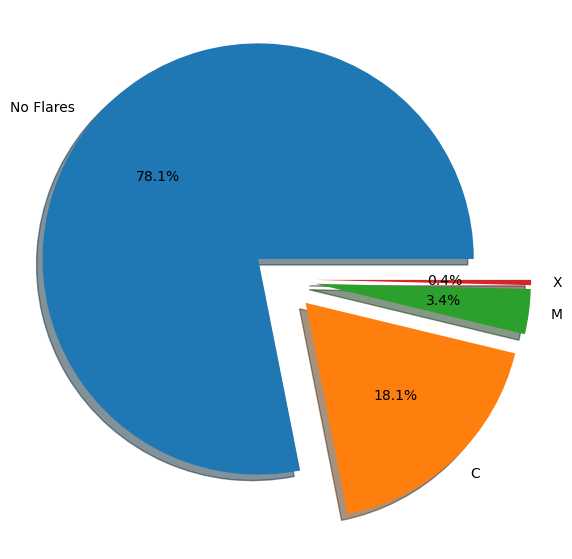

In [34]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.pie(y.value_counts(), labels = ['No Flares', 'C', 'M', 'X'], shadow = True, explode = [0.15, 0.15, 0.15, 0.15], autopct='%0.01f%%')
plt.show()

<h3> Random Forests </h3>

I will use a random forests of decision trees for my model. They are generally good for multiclass classification problems but have some problems with imbalanced dataset. I use f1 scoring because it is important to give lower number of false negatives (to not classify type X as C for example) because it can have a catastrophic consequences but also if the model has a lot of false positives (predicts class C for class X) it would make panic and unnecesary actions may be taken which is not good either. So something in between like f1 scoring is the best.

In [35]:
param_distributions = {
    'n_estimators' : [12, 25, 50, 100, 150, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 11, 15, 20],
    'min_samples_split' : [2, 4, 6, 10, 15],
    'max_features' : ['sqrt', 'log2'],
    'bootstrap' : ['True', 'False']
    
}
randomForest = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_distributions=param_distributions, 
    n_iter = 100,
    n_jobs=-2,
    cv = 10,
    random_state = 7,
    scoring='f1_macro'
)

randomForest.fit(X_train, y_train)  

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-2,
                   param_distributions={'bootstrap': ['True', 'False'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 11, 15, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [2, 4, 6, 10, 15],
                                        'n_estimators': [12, 25, 50, 100, 150,
                                                         200]},
                   random_state=7, scoring='f1_macro')

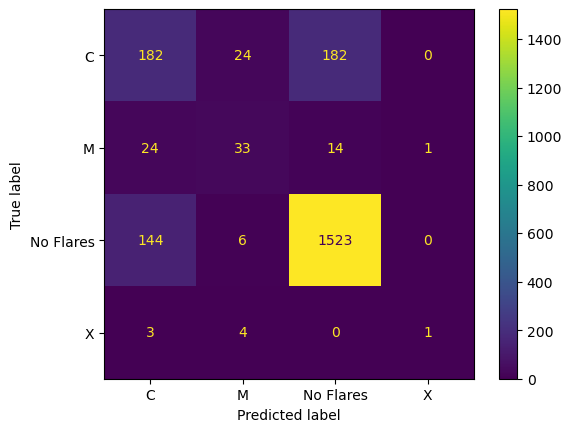

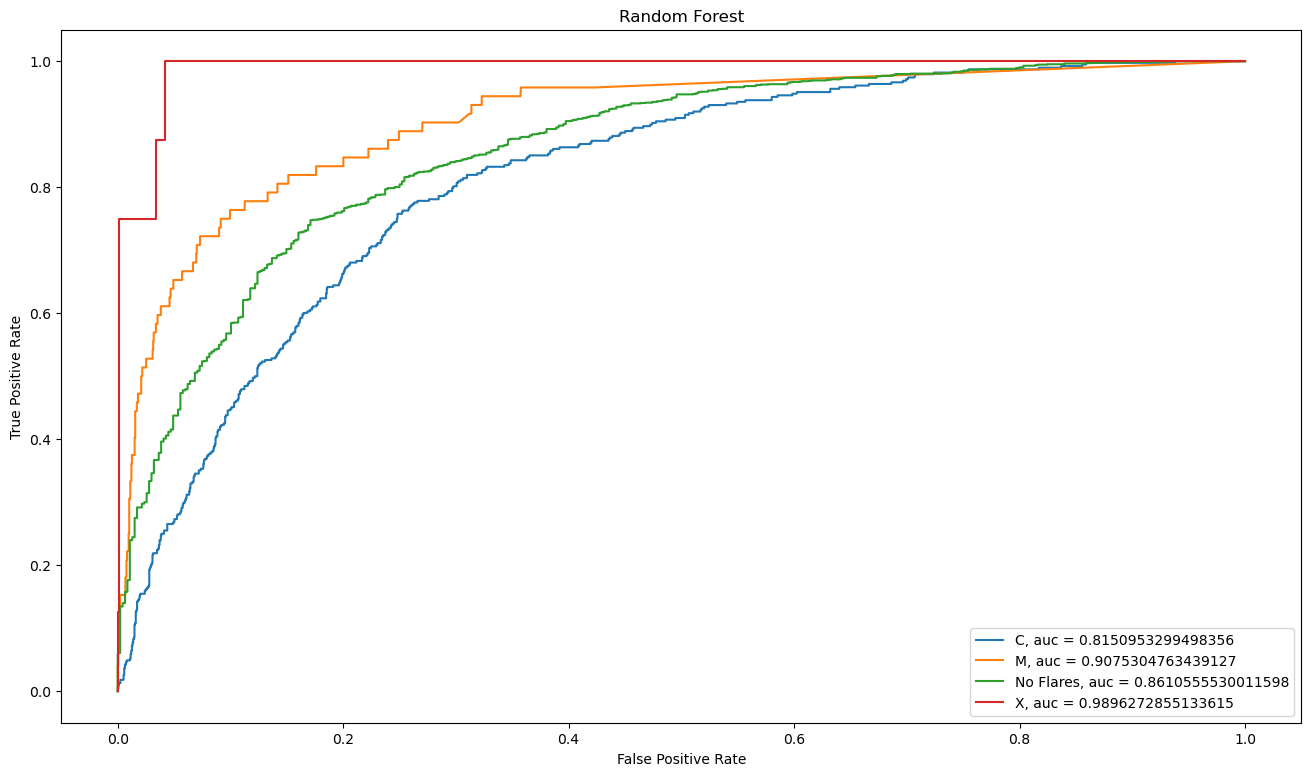

              precision    recall  f1-score   support

           C       0.47      0.52      0.49       353
           M       0.46      0.49      0.47        67
   No Flares       0.91      0.89      0.90      1719
           X       0.12      0.50      0.20         2

    accuracy                           0.81      2141
   macro avg       0.49      0.60      0.52      2141
weighted avg       0.82      0.81      0.82      2141



In [36]:
plotConfusionMatrix(randomForest, X_test, y_test)
plotMulticlassROC(randomForest, X_test, y_test, 'Random Forest')
makeClassificationReport(randomForest, X_test, y_test)

The result from the metrics is pretty good. Note that bordering subclasses can be very similar. For example M9.0 is 9 times stronger than M1.0 and X1.0 is 10 times stronger than M1.0. That means that M9.0 is much closer to X1.0 than M1.0 so it is understandable to classify it as X type flare.

<h3> Gradient boosting </h3>

Gradient boosting is a technique similar to random forests but opperates very well on unbalanced data. As in Random Forests it combines a several 'weak learners' into one 'strong learner'. The thing that makes gradient boosting different is that it fits the new predictor to the errors that the predecessors have made (it learns from the errors of the previous).

In [37]:
param_distributions = {
    'n_estimators': [10, 25, 50, 100, 175, 250],
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0],
    'criterion':['friedman_mse', 'squared_error'],
    'max_depth':[3, 5, 7, 10],
    'min_samples_split':[2, 5, 10, 15],
    'max_features':['sqrt', 'log2']
}

gradientBoosting = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(),
    param_distributions=param_distributions,
    cv = 10,
    n_iter = 100,
    n_jobs = -2,
    random_state = 7,
    scoring = 'f1_macro'
)

In [38]:
gradientBoosting.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-2,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.05, 0.1, 0.25, 0.5,
                                                          0.75, 1.0],
                                        'max_depth': [3, 5, 7, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [10, 25, 50, 100, 175,
                                                         250]},
                   random_state=7, scoring='f1_macro')

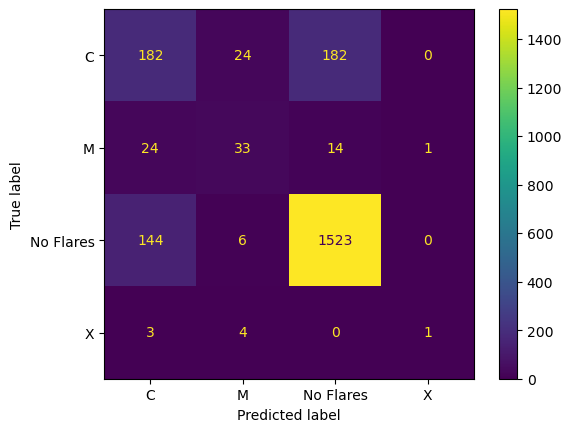

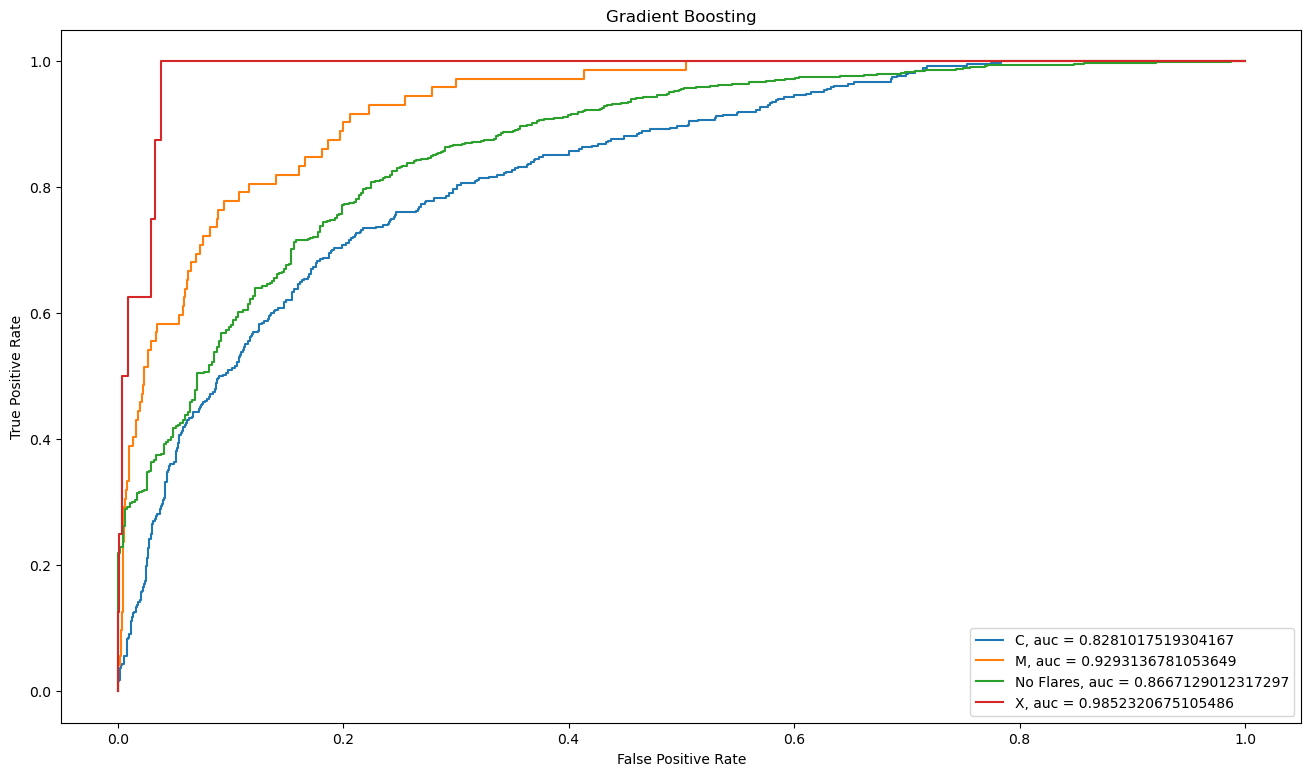

              precision    recall  f1-score   support

           C       0.40      0.62      0.49       250
           M       0.31      0.61      0.41        36
   No Flares       0.96      0.87      0.91      1851
           X       0.25      0.50      0.33         4

    accuracy                           0.84      2141
   macro avg       0.48      0.65      0.54      2141
weighted avg       0.88      0.84      0.85      2141



In [39]:
plotConfusionMatrix(gradientBoosting, X_test, y_test)
plotMulticlassROC(gradientBoosting, X_test, y_test, 'Gradient Boosting')
makeClassificationReport(gradientBoosting, X_test, y_test)

We see that it gives us higher accuracy, better results for No Flares, significantly better recall for C and M classes, but worse results for class X and lower f1-scores for C, M and X. The ROC curves and the AUCs are pretty much the same. Overall gradient boosting did well and almost the same as random forests.

<h3> Logistic Regression </h3>

Logistic regression is one of the classic algorithms for classification. It is very simple but it is not to be underestimated. Again I'm doing Random Cross Validation Search with different hyperparameters and f1-scoring. 

In [40]:
param_distributions = {
    'penalty':['l2'],
    'C':[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000],
    'max_iter':[100, 1000, 2000, 5000],
}

logisticRegression = RandomizedSearchCV(
    estimator = LogisticRegression(class_weight='balanced'),
    param_distributions=param_distributions,
    cv = 10,
    n_iter = 100,
    n_jobs = -2,
    random_state = 7,
    scoring = 'f1_macro'
)

In [41]:
logisticRegression.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
                   n_iter=100, n_jobs=-2,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000, 10000],
                                        'max_iter': [100, 1000, 2000, 5000],
                                        'penalty': ['l2']},
                   random_state=7, scoring='f1_macro')

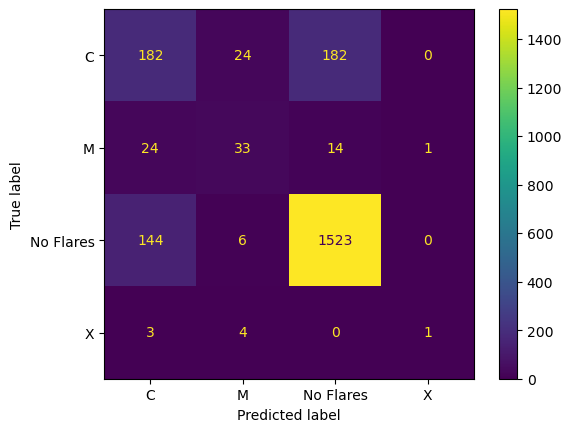

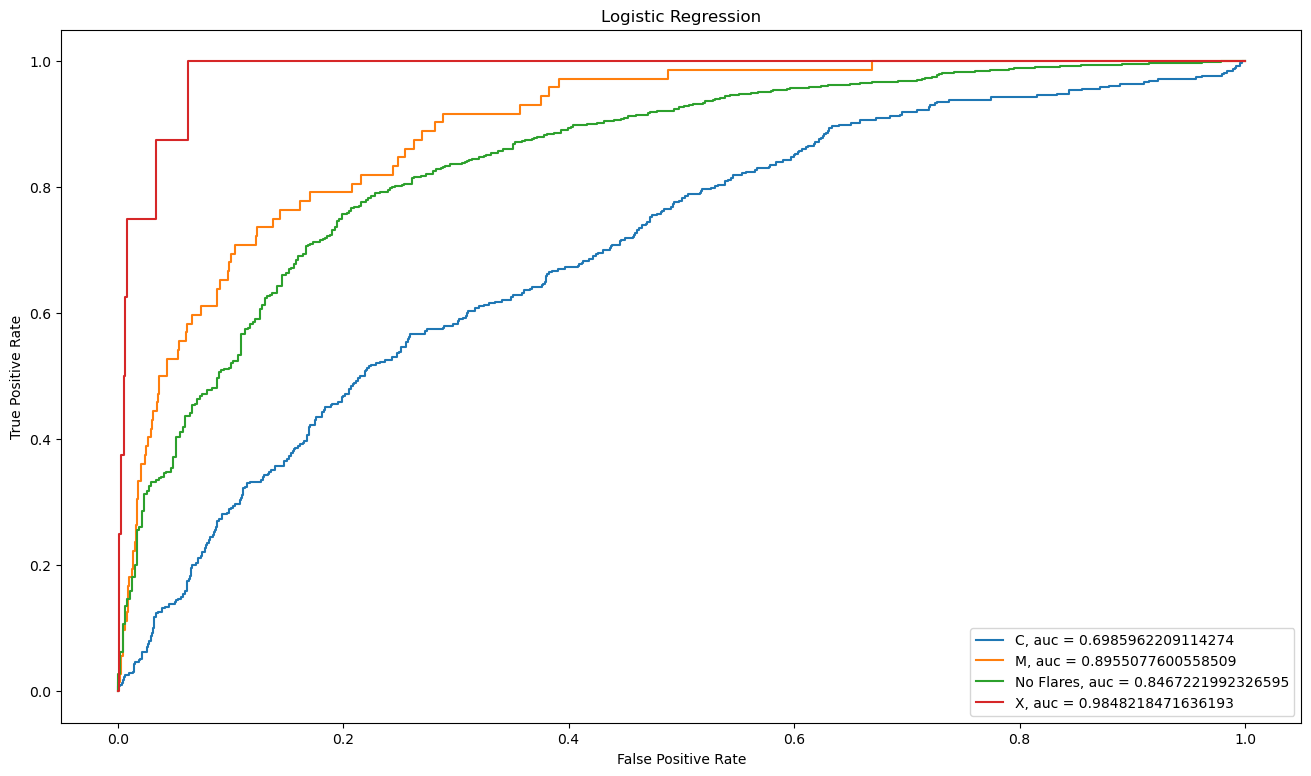

              precision    recall  f1-score   support

           C       0.48      0.38      0.43       496
           M       0.49      0.24      0.32       146
   No Flares       0.80      0.92      0.86      1461
           X       0.75      0.16      0.26        38

    accuracy                           0.74      2141
   macro avg       0.63      0.42      0.47      2141
weighted avg       0.71      0.74      0.71      2141



In [42]:
plotConfusionMatrix(logisticRegression, X_test, y_test)
plotMulticlassROC(logisticRegression, X_test, y_test, 'Logistic Regression')
makeClassificationReport(logisticRegression, X_test, y_test)

From the ROC curve we see that M, X and No Flares are pretty much the same, but there is a large decrease in AUC of C class solar flares. The confusion matrix shows the same - almost half of C type flares have been classified as No Flare and visa versa. In the classification repport all parameters have either stayed around the same level or significantly decreased. From this metrics we can conclude that Logistic Regression is not the best algorith we could use for this problem.

<h2> IV Conclusion </h2>

We saw three machine learning algorithms trying to classify solar flare events - Random Forests, Gradient Boosting and Logistic Regression. Each of them has its advantages and disadvantages. Logistic Regression fits the data extremely fast compared to the other tow but gives lower metrics and makes worse predictions. Random forests and gradient boosting give similar accuracy and AUC but the first one is better at precision and f1-score, while the other at recall. So the user should choose what best suits him. If we compare our results to these of previous research (*Predicting Solar Flares Using SDO/HMI Vector Magnetic Data Products and the Random Forest Algorithm - Chang Liu*) we can see the difference. 

|  | My Research - Recall | Liu's Research - Recall| My Research - Precision | Liu's Research - Precision |
| --- | --- | --- | --- | --- |
| B Flares and lower (practically no flares) | 0.87 | 0.82 | 0.91 | 0.70 |
| C Flares | 0.62 | 0.53 | 0.47 | 0.55 |
| M Flares | 0.61 | 0.68 | 0.46 | 0.65 |
| X Flares | 0.50 | 0.30 | 0.25 | 0.75 |

There are several things that we can do to improve this research. We need more data, especially with rare types of flares - M and X, because as it was shown in the pie diagram above X flares only take 0.4% of the total amount of samples which is extremely insufficiant. I can try using different machine learning algorithms to see how they perform (SVM, Naive Bayes, some Deep Learning algorithms, etc.).